In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import financial.data as fd
import financial.model as fm
import financial.portfolio as fp
import financial.strategies.simulation as fss
from financial.io.file.cache import FileCache
from financial.io.cache import AppendStrategy
from financial.io.file.model import FileModelProvider
from financial.io.cache import NoUpdateStrategy

import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

In [139]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"] + "/"
model = os.environ["MODEL"]

ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))
mp = FileModelProvider(model_path=model)
mc = fm.ModelCache(ds, mp, cache=FileCache(update_strategy=AppendStrategy(), cache_path=model))
uc = fm.UnifiedCache(ds, mc)

In [140]:
from financial.momentum.indicators.modelIndicator import ModelIndicator
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#simulation_indicator = ModelIndicator("keras_cnn")
#import tensorflow as tf
#tf.keras.backend.clear_session()

from financial.momentum.indicators.modelIndicator import ModelIndicator
simulation_indicator = ModelIndicator("cnn", ["M2NS"])

In [141]:
simulation_universe = ['NVDA', 'IYY', 'META', 'GOOG', 'TSLA']
#simulation_universe = ['AAPL']
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

simulation_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=4), fsf.MinimumValueAssetFilter(threshold=0.0)] )
simulation_allocation = fsa.EqualWeightAllocation()
simulation_strategy = fsr.AssetRankingStrategy("Simulation", simulation_universe, simulation_indicator, simulation_filter, simulation_allocation)
print(simulation_strategy)

Simulation
- 5 asset universe: ['NVDA', 'IYY', 'META', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'cnn'}


In [142]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy_simulation = "simulation"
strategy = simulation_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(-1,market) # +1 first day, -1 last day, +2 second day with 1st day momentum

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)

simulation = fss.StockStrategySimulation(uc, strategy, rebalancing, market)
simulation.verbose = True  # verbose 41.7s vs. 27s without trading details
simulation_start_year = 2016
simulation_end_year = 2024
simulation.simulate(start_year=simulation_start_year, end_year=simulation_end_year)

STRATEGY
Simulation
- 5 asset universe: ['NVDA', 'IYY', 'META', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'cnn'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on -1
INITIAL PORTFOLIO
Stocks: ['$$$']
Portfolio value: 1000000.00
Portfolio assets: {'$$$': 1000000.0}
Portfolio stocks: {'$$$': 1000000}
Portfolio weights: {'$$$': 1.0}
+ Rebalance @ 2016-01-28
- Portfolio value: $1000000.00
{'META': 0.25, 'IYY': 0.25, 'GOOG': 0.25, 'TSLA': 0.25}
+ Trade @ 2016-01-29
<class 'numpy.float64'>
195.11215209960938
- Changes: {'$$$': -999804.8878479004, 'IYY': 5201, 'META': 2227, 'TSLA': 19612, 'GOOG': 6729}
- Rotation: 99.98%
Before $1000000.00:
- Stocks: {'$$$': 1000000}
- Assets: {'$$$': 1000000.0}
Selling $$$: -999804.89x$1.00 = $-999804.89
Buying IYY: 5201.00x$48.06 = $249960.07
Buying META: 2227.00x$112.21 = $249891.67
Buying TSLA: 19612.00x$12.75 = $249987.63
Buying GOOG: 6729.00x$37.15 = $24996

In [143]:
year_returns = simulation.year_returns()

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2016:  17.97%
2017:  39.79%
2018:  -5.92%
2019:  37.32%
2020: 121.02%
2021:  43.10%
2022: -43.62%
2023:  90.48%
2024:  38.64%

CUMULATIVE RETURNS
2016:  17.97%
2017:  64.91%
2018:  55.15%
2019: 113.05%
2020: 370.88%
2021: 573.82%
2022: 279.89%
2023: 623.62%
2024: 903.19%


In [144]:
import financial.portfolios.statistics as fps
assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
benchmark_returns = target.returns(ds,'2010-12-31','2024-12-31')
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2010,2024)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)

In [ ]:
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,simulation_start_year,simulation_end_year)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
fss.SimulationReport.simulation_report(benchmark_monthly_returns, fss.accumulate_return)

In [146]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation: {100*rotation:.2f}%")

Average monthly rotation: 24.27%


In [147]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2016:  17.97%
2017:  39.79%
2018:  -5.92%
2019:  37.32%
2020: 121.02%
2021:  43.10%
2022: -43.62%
2023:  90.48%
2024:  38.64%

CUMULATIVE RETURNS
2016:  17.97%
2017:  64.91%
2018:  55.15%
2019: 113.05%
2020: 370.88%
2021: 573.82%
2022: 279.89%
2023: 623.62%
2024: 903.19%


In [148]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:            17.97%   0.00%  -2.58%  10.06%   0.34%   0.43%   0.00%   8.50%  -2.02%  -0.13%  -0.53%   0.00%   3.38%
Monthly cumulative returns
  2016:            17.97%   0.00%  -2.58%   7.22%   7.59%   8.05%   8.05%  17.23%  14.87%  14.71%  14.11%  14.11%  17.97%

SERIES
Monthly returns
2016-01-31    0.000000
2016-02-29   -0.025767
2016-03-31    0.100607
2016-04-30    0.003391
2016-05-31    0.004303
                ...   
2024-08-31   -0.000769
2024-09-30    0.087236
2024-10-31   -0.006811
2024-11-30    0.109632
2024-12-31    0.069007
Length: 108, dtype: float64
Cumulative returns
2016-01-31    0.000000
2016-02-29   -0.025767
2016-03-31    0.072248
2016-04-30    0.075883
2016-05-31    0.080513
                ...   
2024-08-31    6.831929
2024-09-30    7.515153
2024-10-31    7.457154
2024-11-30    8.384331
2024-12-31    9.031914
Length: 108, dtype: float64
CPU times: user 2.23 s, sys: 2.7 ms, total: 2.24 s
Wall time: 2.24 s


In [156]:
def portfolio_statistics(returns, start_date, end_date):
    print(f"From {start_date} to {end_date}")
    print(f"Cumulative return     {100*fps.CumulativeReturn().get(returns):10.2f}%")
    print(f"Annualized return     {100*fps.AnnualizedReturn().get(returns,start_date,end_date):10.2f}%")
    print(f"Maximum drawdown      {100*fps.MaximumDrawdown().get(returns):10.2f}%")
    print(f"Annualized volatility {100*fps.AnnualizedVolatility().get(returns):10.2f}%")
    print(f"Sharpe ratio          {fps.SharpeRatio().get(returns):10.3f}")
    print(f"Sortino ratio         {fps.SortinoRatio().get(returns):10.3f}")

portfolio_statistics(monthly_returns, "2016-01-01", "2024-12-31")
portfolio_statistics(benchmark_returns, "2016-01-01", "2024-12-31")

From 2016-01-01 to 2024-12-31
Cumulative return         903.19%
Annualized return          29.20%
Maximum drawdown          -43.72%
Annualized volatility     114.13%
Sharpe ratio               3.480
Sortino ratio              5.206
From 2016-01-01 to 2024-12-31
Cumulative return         367.67%
Annualized return          18.70%
Maximum drawdown          -33.92%
Annualized volatility      17.18%
Sharpe ratio               2.725
Sortino ratio              3.701


<Axes: >

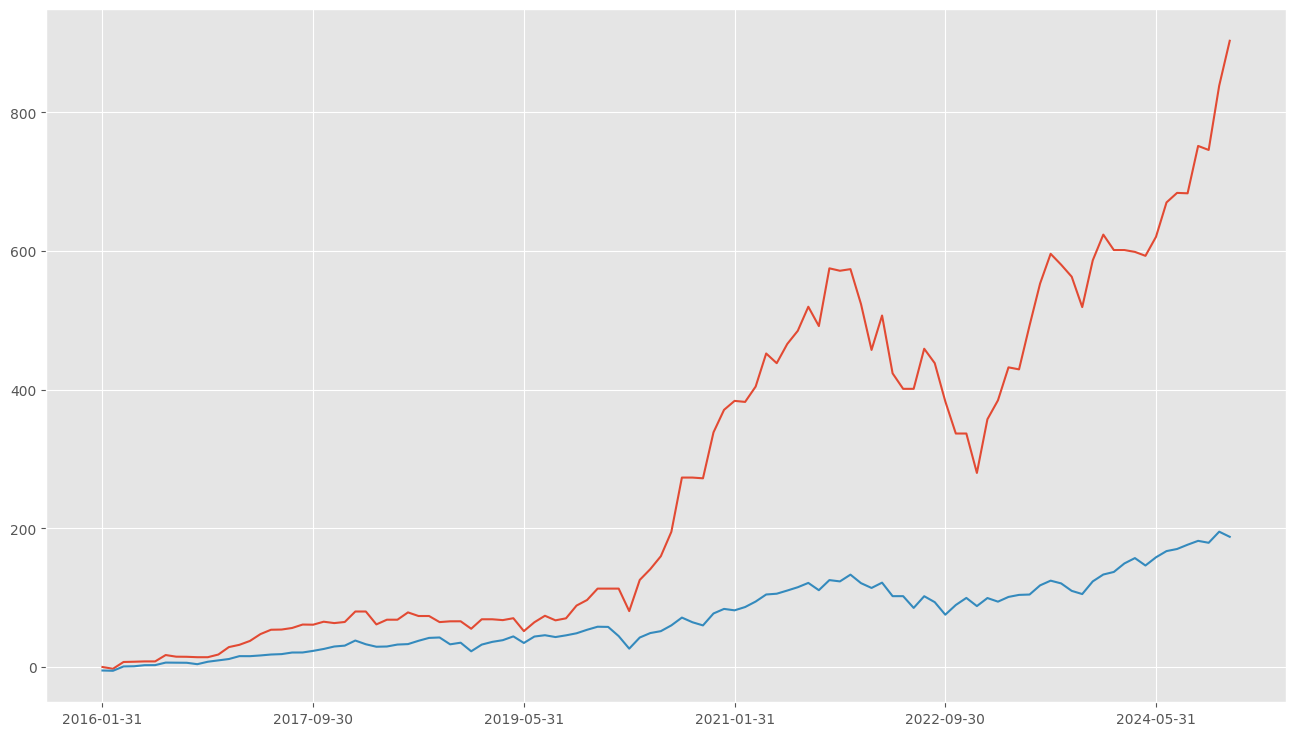

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

fig = plt.figure()

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()